Copyright 2022 The TensorFlow Probability authors

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Install dependencies

In [2]:
!rm -Rf probability
!rm -Rf fun_mc
!rm -Rf inference_gym
!git clone --depth 1 https://github.com/tensorflow/probability.git
!mv probability/spinoffs/fun_mc/fun_mc .
!mv probability/spinoffs/inference_gym/inference_gym .
!pip install optax immutabledict

Cloning into 'probability'...
remote: Enumerating objects: 1590, done.
remote: Counting objects: 100% (1590/1590), done.
remote: Compressing objects: 100% (1367/1367), done.
remote: Total 1590 (delta 393), reused 689 (delta 215), pack-reused 0
Receiving objects: 100% (1590/1590), 37.74 MiB | 12.01 MiB/s, done.
Resolving deltas: 100% (393/393), done.


# Imports

In [3]:
import functools
import fun_mc.using_jax as fun_mc
import inference_gym.using_jax as gym
import tensorflow_probability.substrates.jax as tfp

import numpy as np

import jax
import jax.numpy as jnp
from jax import lax, vmap, random, jit, value_and_grad

import optax

import matplotlib.pyplot as plt

# MEADS implementation

In [4]:
def estimate_largest_eigenvalue_of_covariance(x, remove_mean=True):
  """Estimate the largest eigenvalue of a covariance matrix given a sample.
  
  Implements Algorithm 2 from [1].

  We assume the rows of the input matrix `x` are i.i.d. draws from some
  distribution with (unknown) covariance matrix `sigma`. We want an estimate of
  the largest eigenvalue of `sigma`, but we cannot directly observe `sigma`.
  The naive estimator
  ```
  sigma_hat = x.T.dot(x) / (x.shape[0] - 1)
  max_eig = np.linalg.eigvalsh(sigma_hat).max()
  ```
  can be quite biased if the number of rows in x is not quite large, even
  though `sigma_hat` is unbiased. Instead, we compute the ratio of the sum
  of `sigma_hat`'s squared eigenvalues of to the sum of its eigenvalues.
  Although this estimator is asymptotically biased, it tends to be much more
  accurate than the naive estimator above unless `x` has a very large number
  of rows.

  [1] M.D. Hoffman and P. Sountsov, "Tuning-Free Generalized Hamiltonian Monte
    Carlo," AISTATS 2022.

  Args:
    x: A matrix whose rows are independent draws from the distribution whose
      covariance we are interested in.
    remove_mean: A boolean flag indicating whether or not to replace `x` with
      `x - x.mean(0)`.
  
  Returns:
    max_eig: An estimate of the largest eigenvalue of the covariance of the
      distribution that generated `x`.
  """
  x = x - remove_mean * x.mean(0)
  trace_est = (x**2).sum() / x.shape[0]
  # Note that this has a cost that's quadratic in num_chains. This should only
  # be an issue if cost_per_gradient < num_chains*num_dimensions. In this
  # presumably uncommon event, we could potentially use the Hutchinson
  # trace estimator.
  trace_sq_est = (x.dot(x.T)**2).sum() / x.shape[0]**2
  return trace_sq_est / trace_est


def meads_update(phmc_state, key, fold_to_skip, iteration, target_log_prob_fn,
                 diagonal_preconditioning=True,
                 step_size_multiplier=0.5,
                 damping_slowdown=1.):
  """Apply one step of a self-controlled generalized HMC update.

  Args:
    phmc_state: `fun_mc.prefab.PersistentHamiltonianMonteCarloState` containing
      the current states of the chains. Members of phmc_state should
      have leading dimensions [num_folds, num_chains // num_folds].
    key: `jax.random.PRNGKey` used to drive the chains.
    fold_to_skip: Integer saying which fold to leave unchanged this update.
      Should be initialized to `jnp.zeros(num_folds, np.int32)`.
    iteration: Integer saying how many steps we've taken so far.
      Should be initialized to `jnp.zeros(num_folds, np.int32)`.
    target_log_prob_fn: Callable returning unnormalized log-density.
    diagonal_preconditioning: Boolean saying whether or not to apply diagonal
      preconditioning based on estimates of each dimension's relative scale.
    step_size_multiplier: Float saying how much to multiply our estimate of the
      largest eigenvalue of the Hessian by to get a step size.
    damping_slowdown: Float saying how much to increase damping by in early
      iterations. Damping floor is damping_slowdown/iteration.

  Returns:
    Updated `phmc_state`, a new `key`, `chain_to_skip` incremented by 1 mod
    `num_folds`, and `iteration` incremented by 1.
  """
  momentum_key, new_key = random.split(key, 2)

  num_folds = phmc_state.state.shape[0]
  chains_per_fold = phmc_state.state.shape[1]
  num_chains = num_folds * chains_per_fold
  num_dimensions = phmc_state.state.shape[-1]

  # Randomly refold the walkers.
  perm = random.permutation(random.PRNGKey(iteration // 4), num_chains)
  # TODO(mhoffman): This should really done with a scatter.
  unperm = jnp.eye(num_chains)[perm].argmax(0)
  def refold(x, perm):
    return x.reshape((num_chains,) + x.shape[2:])[perm].reshape(x.shape)
  phmc_state = jax.tree_map(functools.partial(refold, perm=perm), phmc_state)

  if diagonal_preconditioning:
    scale_estimates = phmc_state.state.std(1, keepdims=True)
  else:
    scale_estimates = jnp.ones([num_folds, 1, num_dimensions])
  # Apply preconditioning within-fold to estimate step size and damping.
  self_preconditioned_state = phmc_state.state / scale_estimates
  self_preconditioned_grads = phmc_state.state_grads * scale_estimates
  # Apply preconditioning across folds to do the actual update.
  rolled_scale_estimates = jnp.roll(scale_estimates, 1, 0)

  # Set step size for each fold based on the fold to its left.
  step_size = step_size_multiplier / jnp.sqrt(
      vmap(functools.partial(estimate_largest_eigenvalue_of_covariance,
                             remove_mean=False))(self_preconditioned_grads))
  step_size = jnp.minimum(1., step_size)
  step_size = jnp.roll(step_size, 1)

  # Set damping.
  damping = step_size / jnp.sqrt(
      vmap(estimate_largest_eigenvalue_of_covariance)(
          self_preconditioned_state))
  # Put a floor on the amount of damping in early iterations.
  damping = jnp.maximum(damping_slowdown/iteration, damping)

  noise_fraction = (1 - jnp.exp(-2 * damping))**0.5
  mh_drift = 0.5 * noise_fraction**2

  # TODO(mhoffman): Consider using lax.gather instead of jnp.roll logic.
  # An advantage of roll is that it makes it clear to XLA that there's not
  # actually any dynamic sizing going on here.
  def select_folds(x):
    return jnp.roll(jnp.roll(x, -fold_to_skip, 0)[1:], fold_to_skip, 0)

  def rejoin_folds(updated, original):
    return jnp.roll(jnp.concatenate([original[fold_to_skip][jnp.newaxis],
                                     jnp.roll(updated, -fold_to_skip, 0)], 0),
                    fold_to_skip, 0)

  active_fold_state, phmc_extra = fun_mc.prefab.persistent_hamiltonian_monte_carlo_step(
      jax.tree_map(select_folds, phmc_state),
      target_log_prob_fn=target_log_prob_fn,
      step_size=select_folds(step_size[:, jnp.newaxis, jnp.newaxis] *
                             rolled_scale_estimates),
      num_integrator_steps=1,
      noise_fraction=select_folds(noise_fraction)[:, jnp.newaxis, jnp.newaxis],
      mh_drift=select_folds(mh_drift)[:, jnp.newaxis],
      seed=momentum_key)
  phmc_state = jax.tree_multimap(rejoin_folds, active_fold_state, phmc_state)

  # Revert the ordering of the walkers.
  phmc_state = jax.tree_map(functools.partial(refold, perm=unperm), phmc_state)

  traced = {
      'z_chain': phmc_state.state,
      'is_accepted': phmc_extra.is_accepted,
      'damping': damping,
      'step_size': step_size,
      'level': phmc_state.pmh_state.level,
  }

  return ((phmc_state, new_key, (fold_to_skip + 1) % num_folds, iteration+1),
          traced)


def adam_initialize(x, target_log_prob_fn, num_steps=100, learning_rate=0.05):
  """Use Adam optimizer to get a reasonable initialization for HMC algorithms.

  Args:
    x: Where to initialize Adam.
    target_log_prob_fn: Unnormalized target log-density.
    num_steps: How many steps of Adam to run.
    learning_rate: What learning rate to pass to Adam.

  Returns:
    Optimized version of x.
  """
  optimizer = optax.adam(learning_rate)
  @jit
  def update_step(x, adam_state):
    def g_fn(x):
      return jax.tree_map(lambda x: -x, value_and_grad(target_log_prob_fn)(x))
    tlp, g = g_fn(x)
    updates, adam_state = optimizer.update(g, adam_state)
    return optax.apply_updates(x, updates), adam_state, tlp

  adam_state = optimizer.init(x)
  for i in range(num_steps):
    x, adam_state, tlp = update_step(x, adam_state)
    print('Adam iteration/NLL: %d\t%f' % (i, tlp))
  return x

In [5]:
@functools.partial(jit, static_argnums=(1, 2, 3, 4, 5))
def run_meads(initial_pos,
              target_log_prob_fn,
              num_steps,
              num_chains,
              num_folds,
              thinning=10):
  """Run MEADS to generate samples from an unnormalized density.

  Args:
    initial_pos: Array with shape [num_dimensions] to initialize chains around.
    target_log_prob_fn: Unnormalized target log-density function.
    num_steps: Integer number of iterations to run.
    num_chains: Integer number of chains to use.
    num_folds: Integer number of folds to break the chains into when estimating
      appropriate control parameters.

  Returns:
    samples: Array with shape [num_steps, num_chains, num_dimensions] containing
      the sequence of states of the chains.
  """
  seed = random.PRNGKey(0)
  state_seed, m_seed, slice_seed, mcmc_seed = random.split(seed, 4)

  # Set up initial states for the chains.
  num_dimensions = initial_pos.shape[-1]
  chains_per_fold = num_chains // num_folds
  state_shape = [num_folds, chains_per_fold, num_dimensions]
  initial_pos = initial_pos + 0.01 * random.normal(state_seed, state_shape)
  initial_m = random.normal(m_seed, initial_pos.shape)
  initial_u = 2*random.uniform(slice_seed, state_shape[:-1]) - 1
  initial_state = fun_mc.prefab.persistent_hamiltonian_monte_carlo_init(
      initial_pos, target_log_prob_fn, initial_m, initial_u)

  curried_update = functools.partial(
      meads_update,
      target_log_prob_fn=target_log_prob_fn,
      diagonal_preconditioning=True,
      step_size_multiplier=0.5,
      damping_slowdown=1.)
  # Nested call to fun_mc.trace implements thinning.
  return fun_mc.trace((initial_state, mcmc_seed, 0, 0),
                      lambda *state: fun_mc.trace(
                          state, curried_update, thinning, trace_mask=False),
                      num_steps//thinning)[1]

# Since MEADS is a tuning-free algorithm, you should be able to swap out
# GermanCreditNumericSparseLogisticRegression for any other inference gym
# target distribution without additional tuning (although you might need to
# increase `num_steps`.
target = gym.targets.VectorModel(
    gym.targets.GermanCreditNumericSparseLogisticRegression())
target_log_prob_fn = fun_mc.transform_log_prob_fn(
    lambda x: (target.unnormalized_log_prob(x), ()),
    target.default_event_space_bijector)
num_dimensions = target.event_shape[0]
num_steps = 1000
thinning = 10
num_chains = 128
num_folds = 4

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6690: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6690: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:3611: UserWarning: Explicitly requested dtyp

In [7]:
%%time

# Note that the first run triggers compilation (which takes a few seconds) and 
# dataset download (which can also take a little time). For "easy" problems this
# can dominate the runtime. To get a better sense of how much time is actually
# spent on compute, just run this cell twice.
initial_state = adam_initialize(jnp.zeros(target.event_shape),
                                lambda x: target_log_prob_fn(x)[0])
result = run_meads(initial_state,
                   target_log_prob_fn,
                   num_steps, num_chains, num_folds, thinning)

Adam iteration/NLL: 0	753.013062
Adam iteration/NLL: 1	700.834106
Adam iteration/NLL: 2	659.783264
Adam iteration/NLL: 3	630.853027
Adam iteration/NLL: 4	610.618652
Adam iteration/NLL: 5	596.124023
Adam iteration/NLL: 6	584.096558
Adam iteration/NLL: 7	571.852722
Adam iteration/NLL: 8	559.079285
Adam iteration/NLL: 9	547.278748
Adam iteration/NLL: 10	538.225037
Adam iteration/NLL: 11	533.297974
Adam iteration/NLL: 12	533.058044
Adam iteration/NLL: 13	536.620178
Adam iteration/NLL: 14	541.386230
Adam iteration/NLL: 15	544.342285
Adam iteration/NLL: 16	544.214661
Adam iteration/NLL: 17	541.702454
Adam iteration/NLL: 18	538.296875
Adam iteration/NLL: 19	535.241821
Adam iteration/NLL: 20	533.131226
Adam iteration/NLL: 21	532.007263
Adam iteration/NLL: 22	531.632935
Adam iteration/NLL: 23	531.708191
Adam iteration/NLL: 24	531.978943
Adam iteration/NLL: 25	532.268494
Adam iteration/NLL: 26	532.473450
Adam iteration/NLL: 27	532.545105
Adam iteration/NLL: 28	532.467651
Adam iteration/NLL: 29	5

The chains converge to their stationary distribution pretty quickly.

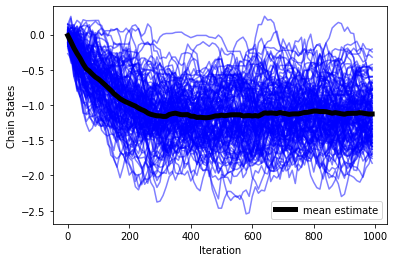

In [8]:
t = np.arange(0, num_steps, thinning)

plt.plot(t, result['z_chain'].reshape([num_steps // thinning, -1, num_dimensions])[:, :, 0],
         'b', alpha=0.5)
plt.plot(t, result['z_chain'].reshape([num_steps // thinning, -1, num_dimensions])[:, :, 0].mean(1),
         'k', linewidth=5, label='mean estimate')
plt.xlabel('Iteration')
plt.ylabel('Chain States')
plt.legend(loc='best')
plt.show()

The control parameters converge even faster, and are relatively consistent across folds (control parameters for different folds are shown in different colors).

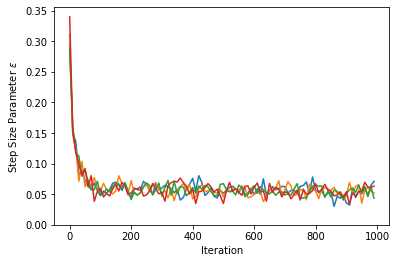

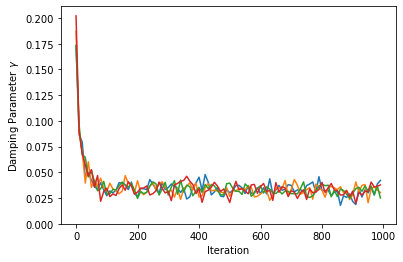

In [9]:
plt.plot(t, result['step_size'])
plt.xlabel('Iteration')
plt.ylabel('Step Size Parameter $\epsilon$')
plt.ylim(0, None)
plt.show()

plt.plot(t, result['damping'])
plt.xlabel('Iteration')
plt.ylabel('Damping Parameter $\gamma$')
plt.ylim(0, None)
plt.show()

The standard-deviation estimates (used for preconditioning) are a bit noisier, but nonetheless converge to a useful range reasonably quickly.

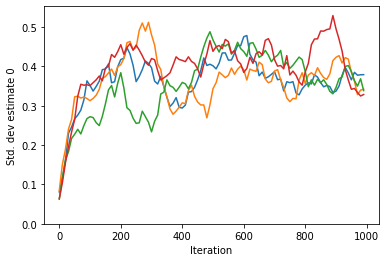

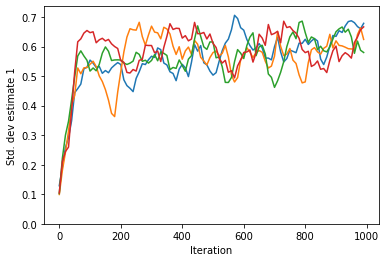

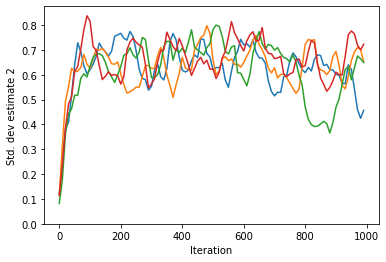

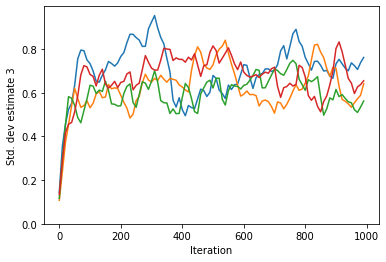

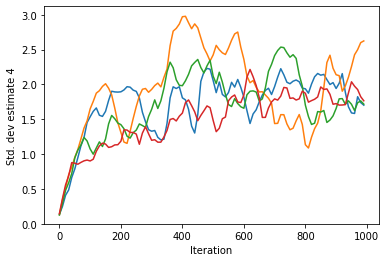

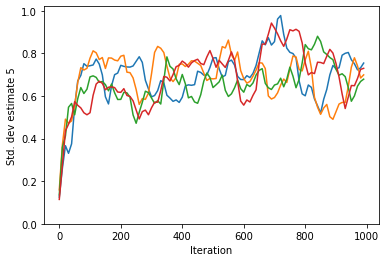

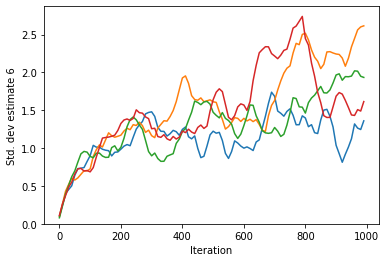

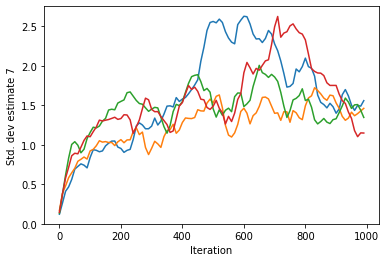

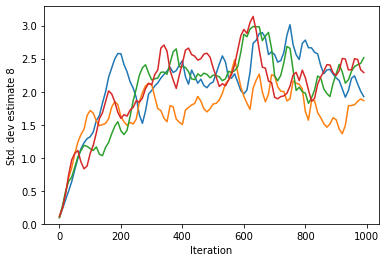

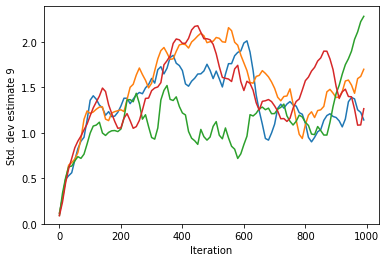

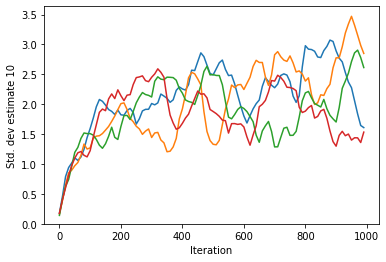

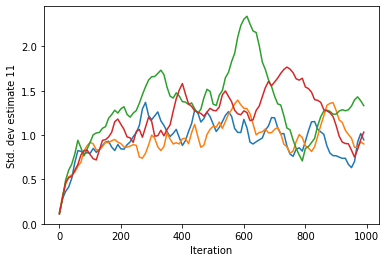

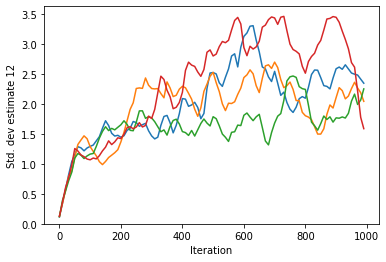

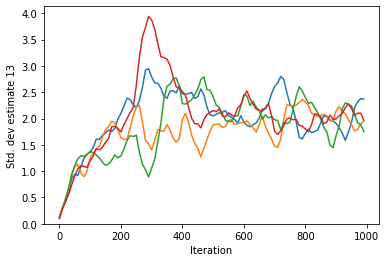

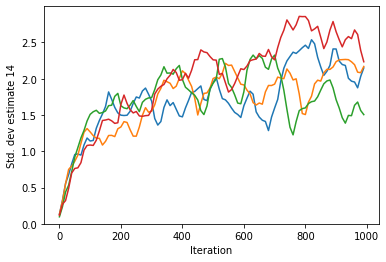

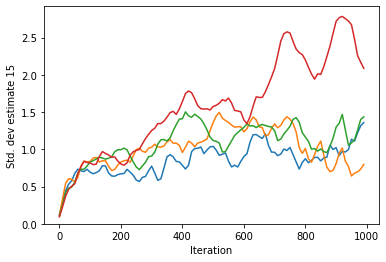

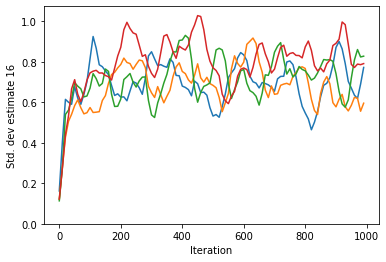

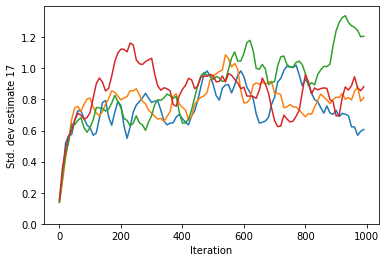

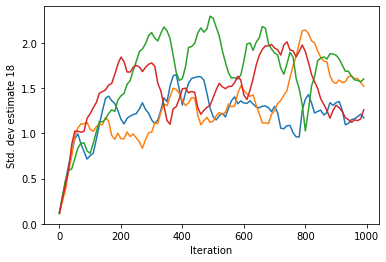

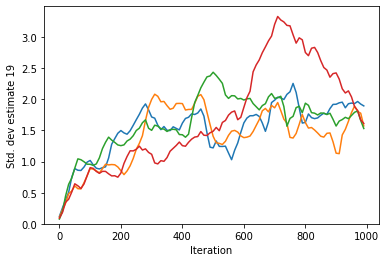

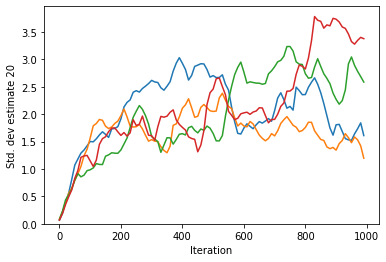

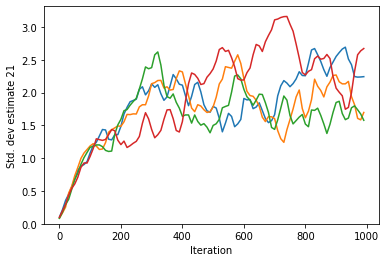

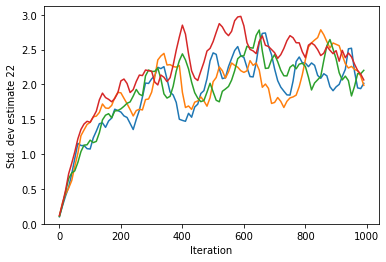

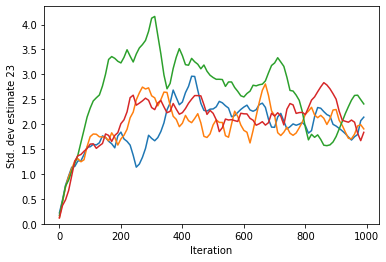

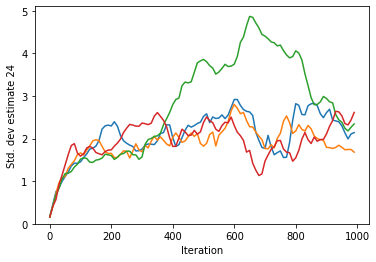

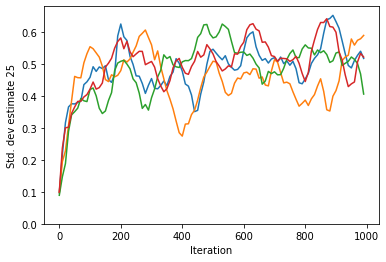

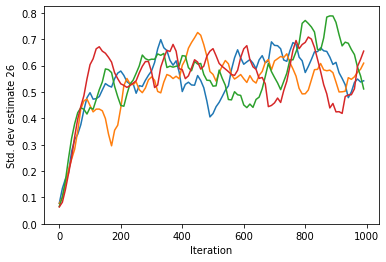

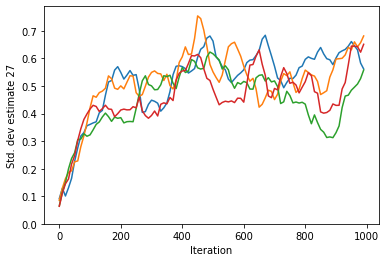

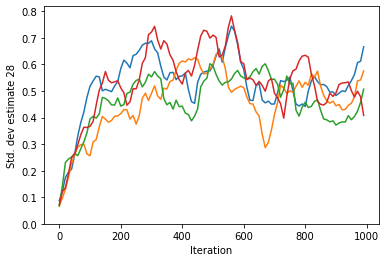

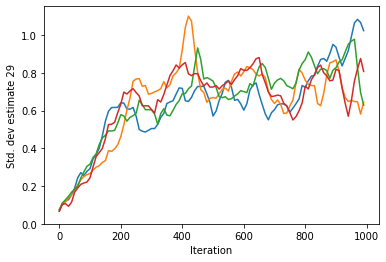

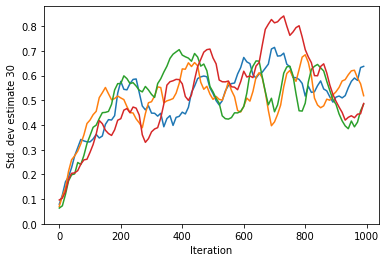

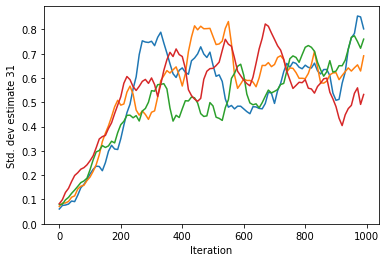

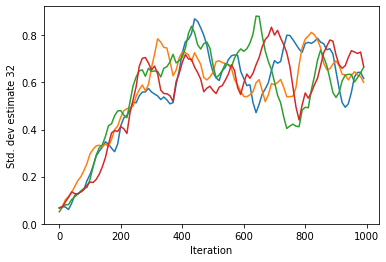

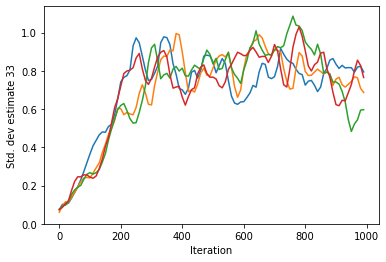

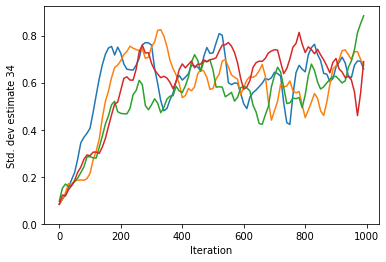

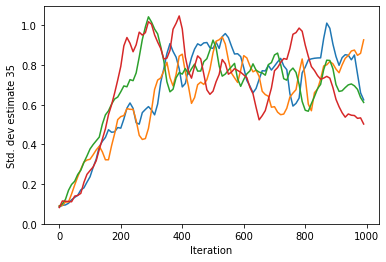

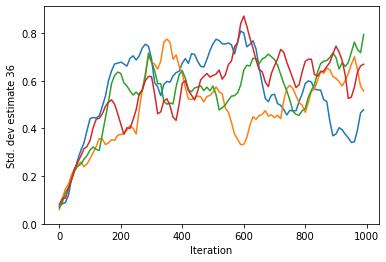

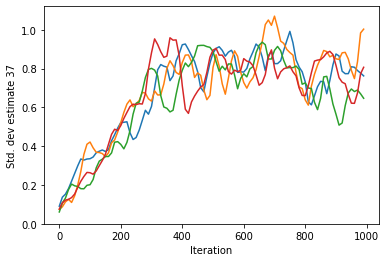

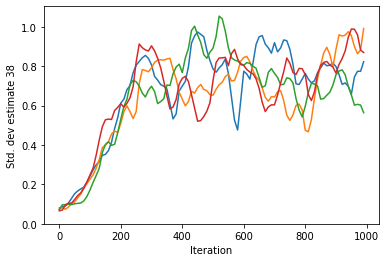

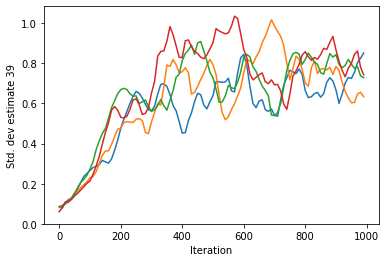

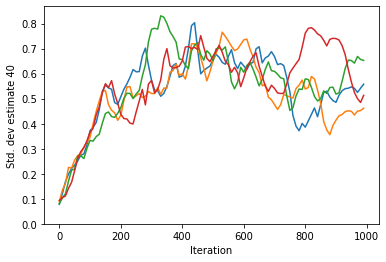

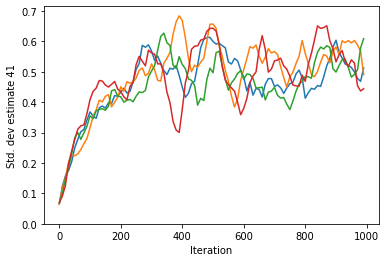

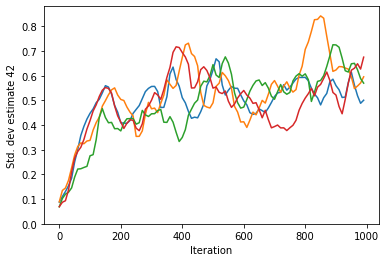

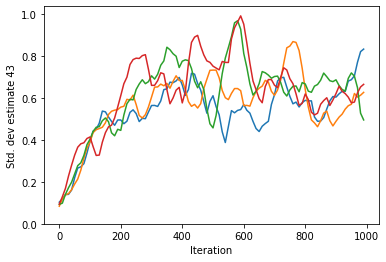

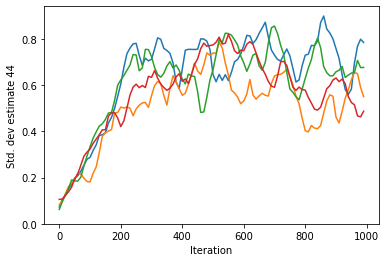

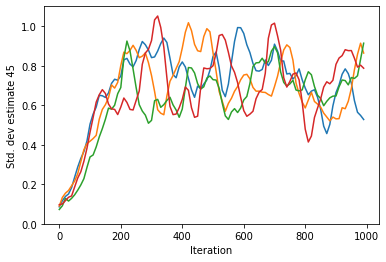

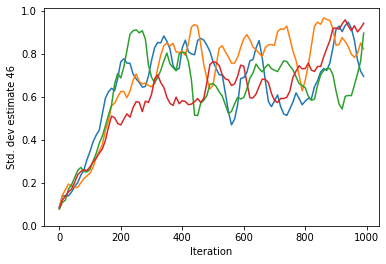

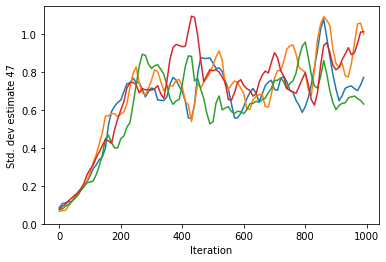

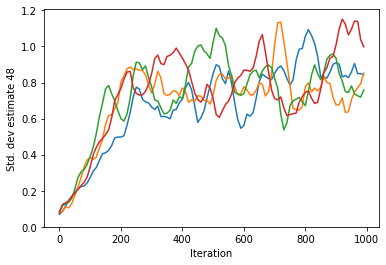

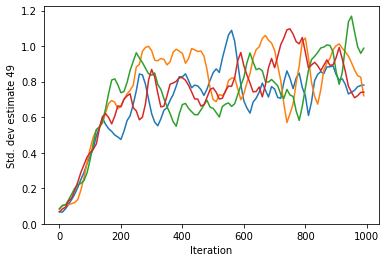

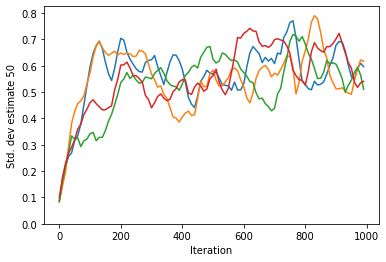

In [10]:
std_dev_ests = result['z_chain'].std(2)
for dimension in range(num_dimensions):
  plt.plot(t, std_dev_ests[:, :, dimension])
  plt.xlabel('Iteration')
  plt.ylabel('Std. dev estimate {}'.format(dimension))
  plt.ylim(0, None)
  plt.show()